<img src="http://www.reeem.org/wp-content/uploads/2017/10/cropped-reeem-logo-transparent.png" width="300" style="float: left">
<img src="http://reiner-lemoine-institut.de//wp-content/uploads/2015/09/rlilogo.png" width="100" style="float: right">

# REEEM-DB - ESME

__copyright__ 	= "© Reiner Lemoine Institut" <br>
__license__ 	= "GNU Affero General Public License Version 3 (AGPL-3.0)" <br>
__url__ 		= "https://www.gnu.org/licenses/agpl-3.0.en.html" <br>
__author__ 		= "Ludwig Hülk" <br>

# Import

In [1]:
# basic
import sys
import os
import getpass
import pandas as pd
import numpy as np
import json
import pathlib
from sqlalchemy import *
# plot
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.graph_objs as go
import plotly.offline as pltly
import colorlover as cl
import seaborn as sns
# notebook
from IPython.display import Image
from IPython.core.display import HTML 

pltly.init_notebook_mode(connected=True)
%matplotlib inline

version = 'v0.2.0'
project = 'REEEM'

# Database Connection

This function creates a database connection to the **reeem_db**.<br>
The default user is **reeem_vis**, a user that has only read rights.

This section establishes the database connection and asks for the **password**.<br>
The username can be changed in the corresponding function above.<br>
If you don't have a username or forgot your password please contact your database admins.

In [2]:
def reeem_session():
    """SQLAlchemy session object with valid connection to reeem database"""
    
    print('Please provide connection parameters to database:\n' +
              'Hit [Enter] to take defaults')
    host = '130.226.55.43' # input('host (default 130.226.55.43): ')
    port = '5432' # input('port (default 5432): ')
    database = 'reeem' # input("database name (default 'reeem'): ")
    user = 'reeem_vis' # input('user (default postgres): ')
    # password = input('password: ')
    password = getpass.getpass(prompt='password: ',
                                   stream=sys.stderr)
    con = create_engine(
            'postgresql://' + '%s:%s@%s:%s/%s' % (user,
                                                  password,
                                                  host,
                                                  port,
                                                  database)).connect()
    print('Password correct! Database connection established.')
    return con

con = reeem_session()

C:\Anaconda3\envs\reeem-vis\lib\site-packages\ipykernel_launcher.py:12: UserWarning:

The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel



Please provide connection parameters to database:
Hit [Enter] to take defaults
password: ········
Password correct! Database connection established.


# Table Info

In [3]:
# Database
schema = 'model_draft'
table_in = 'reeem_esme_input'
table_out = 'reeem_esme_output'
folder = 'esme'

pathlib.Path('data/'+folder).mkdir(parents=True, exist_ok=True) 
print("Database Schema:", schema +'\n'+ "Input table:", table_in +'\n'+ 
      "Output table:", table_out +'\n'+ "Created folder:", folder )

Database Schema: model_draft
Input table: reeem_esme_input
Output table: reeem_esme_output
Created folder: esme


## Database Query

This section is used to query the database tables (**table_in** and **table_out**).<br>

In [4]:
# Number of entries in table
sql = text("""
    SELECT  'In' AS data, count(*) AS count
    FROM    {0}.{1}
    UNION ALL
    SELECT  'Out' AS data, count(*) AS count
    FROM    {0}.{2}""".format(schema, table_in, table_out))
df_num = pd.read_sql_query(sql, con)
df_num

,data,count
0,In,0
1,Out,666776


In [5]:
# Pathways
column = 'pathway' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3} 
    ORDER BY {3}; """.format(schema, table_in, table_out, column))
df_path = pd.read_sql_query(sql, con)
df_path

,data,pathway,count
0,Out,PathwayNA,666776


In [6]:
# Versions
column = 'framework,pathway,version,updated' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3} 
    ORDER BY updated,{3}; """.format(schema, table_in, table_out, column))
df_ver = pd.read_sql_query(sql, con)
df_ver

,data,framework,pathway,version,updated,count
0,Out,FrameworkV1,PathwayNA,DataV3,2019-01-08 23:00:00+00:00,666776


In [7]:
# Years
column = 'year' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3} 
    ORDER BY {3} ; """.format(schema, table_in, table_out, column))
df_year = pd.read_sql_query(sql, con)
df_year

,data,year,count
0,Out,2020,167174
1,Out,2030,171991
2,Out,2040,168465
3,Out,2050,159146


In [8]:
# Regions / Scenario
column = 'scenario' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3}
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3}; """.format(schema, table_in, table_out, column))
df_reg = pd.read_sql_query(sql, con)
df_reg

,data,scenario,count
0,Out,RM,235072
1,Out,RM-F2R,216445
2,Out,RM-NCCS,215259


In [9]:
# Categories
column = 'category' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3}; """.format(schema, table_in, table_out, column))
df_cat = pd.read_sql_query(sql, con)
df_cat

,data,category,count
0,Out,Emissions,7196
1,Out,Biofuel supply,14392
2,Out,Captured CO2,35980
3,Out,System wide energy use,43176
4,Out,Industrial energy consumption,43176
5,Out,Captured CO2 using bioenergy,35980
6,Out,Transport energy consumption,43176
7,Out,Building energy consumption,43176
8,Out,Transport fuel use,158312
9,Out,Power Generation,155860


In [10]:
# Indicators
column = 'category,indicator,unit' # id, pathway, version, region, year, indicator, category, value, unit
sql = text("""
    SELECT  'In' AS data, {3}, count(*) AS count
    FROM    {0}.{1}
    GROUP BY {3} 
    UNION ALL 
    SELECT  'Out' AS data, {3}, count(*) AS count
    FROM    {0}.{2}
    GROUP BY {3}
    ORDER BY category, indicator; """.format(schema, table_in, table_out, column))
df_ind = pd.read_sql_query(sql, con)
df_ind.index.names = ['rid']
df_ind

,data,category,indicator,unit,count
rid,,,,,
0,Out,Biofuel supply,Biofuel-DomProd,TWh,7196
1,Out,Biofuel supply,Biofuel-Import,TWh,7196
2,Out,Building energy consumption,Biomass_BF,TWh,7196
3,Out,Building energy consumption,Electricity_BF,TWh,7196
4,Out,Building energy consumption,Gas_BF,TWh,7196
5,Out,Building energy consumption,Network Hot Water_BF,TWh,7196
6,Out,Building energy consumption,Oil_BF,TWh,7196
7,Out,Building energy consumption,Solar_BF,TWh,7196
8,Out,Captured CO2,Biofuels_CC,MtCO2 captured,7196


In [11]:
# Write data as CSV file
csvname = 'data/{0}/reeem_{0}_indicators.csv'.format(folder)
df_ind.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

Data saved to file: data/esme/reeem_esme_indicators.csv


## Table metadata

Access the metadata from the database tables and write metadata string as JSON file.<br>

In [12]:
# Input Metadata
sql = text("""SELECT obj_description('{0}.{1}'::regclass);""".format(schema, table_in))
meta_in = pd.read_sql_query(sql, con).loc[:,'obj_description'].iloc[0]
print(meta_in)

# Save data to JSON file
fname_in = 'data/{0}/{1}_metadata.json'.format(folder, table_in)
with open(fname_in, 'w') as metafile:
    json.dump(json.loads(meta_in), metafile, indent=4)
    print("Data saved to file:", fname_in)

{"title": "REEEM ESME Input",
    "description": "",
    "language": [ "eng" ],
    "spatial": 
        {"location": "none",
        "extent": "none",
        "resolution": "none"},
    "temporal": 
        {"reference_date": "none",
        "start": "none",
        "end": "none",
        "resolution": "none"},
    "sources": [
        {"name": "none", "description": "none", "url": "none", "license": "none", "copyright": "none"} ],
    "license":
        {"id": "tba",
        "name": "tba",
        "version": "tba",
        "url": "tba",
        "instruction": "tba",
        "copyright": "tba"},
    "contributors": [
        {"name": "Ludee", "email": "none", "date": "2019-01-09", "comment": "Create table and metadata"},
        {"name": "4lm", "email": "none", "date": "2019-02-07", "comment": "Alter table, add missing columns"} ],
    "resources": [
        {"name": "model_draft.reeem_esme_input",
        "format": "PostgreSQL",
        "fields": [
            {"name": "id", "descript

In [13]:
# Output Metadata
sql = text("""SELECT obj_description('{0}.{1}'::regclass);""".format(schema, table_out))
meta_out = pd.read_sql_query(sql, con).loc[:,'obj_description'].iloc[0]
print(meta_out)

# Save data to JSON file
fname_out = 'data/{0}/{1}_metadata.json'.format(folder, table_out)
with open(fname_out, 'w') as metafile:
    json.dump(json.loads(meta_out), metafile, indent=4)
    print("Data saved to file:", fname_out)

{"title": "REEEM ESME Output",
    "description": "Health externalities (unit cost factors) due to air pollution",
    "language": [ "eng" ],
    "spatial": 
        {"location": "none",
        "extent": "",
        "resolution": ""},
    "temporal": 
        {"reference_date": "",
        "start": "2020",
        "end": "2050",
        "resolution": "10 years"},
    "sources": [
        {"name": "ESME Model", "description": "tba", "url": "https://openenergy-platform.org/factsheets/models/144/", "license": "none", "copyright": "Energy Technologies Institute (ETI), UCL"} ],
    "license":
        {"id": "tba",
        "name": "tba",
        "version": "tba",
        "url": "tba",
        "instruction": "tba",
        "copyright": "tba"},
    "contributors": [
        {"name": "Ludee", "email": "none", "date": "2019-01-09", "comment": "Create table and metadata"},
        {"name": "4lm", "email": "none", "date": "2019-01-31", "comment": "Alter table, add missing columns"} ],
    "resour

# View 1: One indicator for one region in one pathway over time
## Database Query

This section can be used to query one specific **indicator** (_filter 1_) for one specific **region** (_filter 2_) from one database table (_table_).<br>
Indicators are identified by the **nid**.<br>
It is possible to select one specific **pathway** (_filter 3_) and one specific data **version** (_filter 4_).<br>
To querry additional coulmns from the database table add the names to the **SELECT** statement (_column_).<br>
The sortation is done by the **ORDER BY** (_sorting_).<br>
The result from the database is saved to a pandas.DataFrame (**df_1**) and can be printed.

In [14]:
# Database select (SQL)
sql = text("""
    SELECT  pathway, version, scenario, year, nid, category, indicator, value, unit  -- column
    FROM    {0}.{1}                               -- table
    WHERE   (indicator = 'Total_CC' OR indicator = 'CO2 MAC')
        AND (scenario = 'RM'                      -- filter 3
        AND year = '2050')
        --AND framework = 'FrameworkV1'              
        --AND version = 'DataV3'                    -- filter 4
    ORDER BY pathway, version, year, indicator, nid;""".format(schema, table_out))
df_1 = pd.read_sql_query(sql, con)
print(df_1)

        pathway version scenario  year   nid      category indicator    value  \
0     PathwayNA  DataV3       RM  2050  1801  Cost metrics   CO2 MAC  400.710   
1     PathwayNA  DataV3       RM  2050  1802  Cost metrics   CO2 MAC  455.460   
2     PathwayNA  DataV3       RM  2050  1803  Cost metrics   CO2 MAC  349.100   
3     PathwayNA  DataV3       RM  2050  1804  Cost metrics   CO2 MAC  268.170   
4     PathwayNA  DataV3       RM  2050  1805  Cost metrics   CO2 MAC  611.470   
5     PathwayNA  DataV3       RM  2050  1806  Cost metrics   CO2 MAC  510.810   
6     PathwayNA  DataV3       RM  2050  1807  Cost metrics   CO2 MAC  568.000   
7     PathwayNA  DataV3       RM  2050  1808  Cost metrics   CO2 MAC  335.140   
8     PathwayNA  DataV3       RM  2050  1809  Cost metrics   CO2 MAC  396.010   
9     PathwayNA  DataV3       RM  2050  1810  Cost metrics   CO2 MAC  558.080   
10    PathwayNA  DataV3       RM  2050  1811  Cost metrics   CO2 MAC  294.970   
11    PathwayNA  DataV3     

## Metadata

The important information from the above select (**df_1**) is collected in a Dictionary (**info_dict_1**).

In [15]:
# Facts dict
info_dict_1 = {}
info_dict_1['Filename'] = ['{}_reeem_esme_css_plot_1' .format(pd.to_datetime('today').strftime("%Y-%m-%d"))]
info_dict_1['Category'] = df_1.loc[:,'category'].unique().tolist()
info_dict_1['Indicator'] = df_1.loc[:,'indicator'].unique().tolist()
info_dict_1['Unit'] = df_1.loc[:,'unit'].unique().tolist()
info_dict_1['Pathway'] = df_1.loc[:,'pathway'].unique()
info_dict_1['Year'] = df_1.loc[:,'year'].unique().tolist()
info_dict_1['Scenario'] = df_1.loc[:,'scenario'].unique()
info_dict_1['X-Axis'] = ['{0} in {1}'.format(info_dict_1['Indicator'][1], info_dict_1['Unit'][1])]
info_dict_1['Y-Axis'] = ['{0} in {1}'.format(info_dict_1['Indicator'][0], info_dict_1['Unit'][0])]
info_dict_1['Title'] = ['{0} vs. {1}'.format(info_dict_1['Category'][1], info_dict_1['Category'][0])]
info_dict_1['Metadata'] = meta_out

# Print facts
for x in info_dict_1:
    print(x,':',info_dict_1[x])

Filename : ['2019-02-25_reeem_esme_css_plot_1']
Category : ['Cost metrics', 'Captured CO2']
Indicator : ['CO2 MAC', 'Total_CC']
Unit : ['£/tCO2', 'MtCO2 captured']
Pathway : ['PathwayNA']
Year : [2050]
Scenario : ['RM']
X-Axis : ['Total_CC in MtCO2 captured']
Y-Axis : ['CO2 MAC in £/tCO2']
Title : ['Captured CO2 vs. Cost metrics']
Metadata : {"title": "REEEM ESME Output",
    "description": "Health externalities (unit cost factors) due to air pollution",
    "language": [ "eng" ],
    "spatial": 
        {"location": "none",
        "extent": "",
        "resolution": ""},
    "temporal": 
        {"reference_date": "",
        "start": "2020",
        "end": "2050",
        "resolution": "10 years"},
    "sources": [
        {"name": "ESME Model", "description": "tba", "url": "https://openenergy-platform.org/factsheets/models/144/", "license": "none", "copyright": "Energy Technologies Institute (ETI), UCL"} ],
    "license":
        {"id": "tba",
        "name": "tba",
        "versio

## Plot

This is a basic plot with [matplotlib](https://matplotlib.org/).<br>
The title and y-axis labels are taken from the **info_dict_1**. They can be exchanged with manual text.

In [16]:
print(df_1.loc[df_1['indicator'] == 'Total_CC'])

        pathway version scenario  year   nid      category indicator    value  \
600   PathwayNA  DataV3       RM  2050  1801  Captured CO2  Total_CC  132.281   
601   PathwayNA  DataV3       RM  2050  1802  Captured CO2  Total_CC  119.007   
602   PathwayNA  DataV3       RM  2050  1803  Captured CO2  Total_CC  161.157   
603   PathwayNA  DataV3       RM  2050  1804  Captured CO2  Total_CC  188.071   
604   PathwayNA  DataV3       RM  2050  1805  Captured CO2  Total_CC  111.221   
605   PathwayNA  DataV3       RM  2050  1806  Captured CO2  Total_CC  145.522   
606   PathwayNA  DataV3       RM  2050  1807  Captured CO2  Total_CC  115.096   
607   PathwayNA  DataV3       RM  2050  1808  Captured CO2  Total_CC  159.409   
608   PathwayNA  DataV3       RM  2050  1809  Captured CO2  Total_CC  140.578   
609   PathwayNA  DataV3       RM  2050  1810  Captured CO2  Total_CC  106.212   
610   PathwayNA  DataV3       RM  2050  1811  Captured CO2  Total_CC  159.286   
611   PathwayNA  DataV3     

(0, 944.6614999999999)

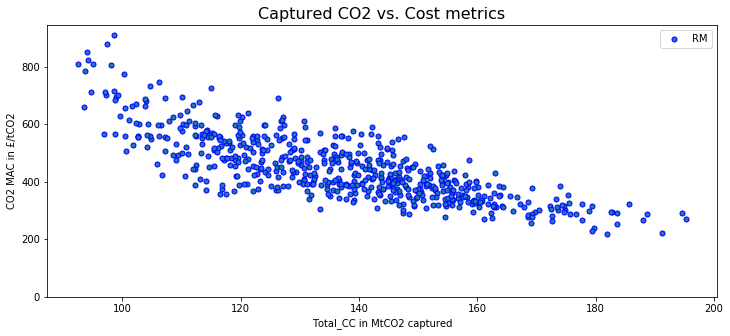

In [17]:
# Plot for one indicator and one pathway
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot()
# plt.title(r'CO2-Emissions in EU28', fontsize=16)  # Manual title
plt.title(*info_dict_1['Title'], fontsize=16)         # Title from info
# plt.ylabel(r'CO2-Emissions in Mt')                # Manual label
plt.ylabel(*info_dict_1['Y-Axis'])                    # Label from info
plt.xlabel(*info_dict_1['X-Axis'])                    # Label from info
plt.plot(df_1.loc[:,'value'].loc[df_1['indicator'] == 'Total_CC'], df_1.loc[:,'value'].loc[df_1['indicator'] == 'CO2 MAC'], 
         marker="o",  markersize=5, linestyle = 'None', markeredgecolor='b',)
plt.legend(info_dict_1['Scenario'])
ax.set_ylim(ymin=0)

## Interactive Plot

This is a basic interactive plot with [Plotly](https://plot.ly/python/).<br>
You can hover over the elements of the plot and observe the data.

In [18]:
# Interactive plot for one indicator and one pathway
data = [go.Scatter(
    x = df_1.loc[:,'value'].loc[df_1['indicator'] == 'Total_CC'],
    y = df_1.loc[:,'value'].loc[df_1['indicator'] == 'CO2 MAC'],
    mode = 'markers',
    marker = dict(
          color = 'rgb(17, 157, 255)',
          size = 5,
          opacity = 0.5,
          line = dict(
            color = 'rgb(0, 0, 0)',
            width = 2)),
    name = info_dict_1['Scenario'])]

# Set layout
layout = go.Layout(
    height=400, width = 800,
    #title='CO2-Emissions in EU28',
    title=''.join(info_dict_1['Title']),
    # yaxis=dict(title='CO2-Emissions in Mt') )
    yaxis=dict(title=''.join(info_dict_1['Y-Axis'])) )
ifig = go.Figure(data=data, layout=layout)
pltly.iplot(ifig)

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.

In [19]:
# Save plot as file
plotname = ('data/' + str({0}) + '/' + str({1}) +'.png').format(folder, *info_dict_1['Filename'])
fig.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

Plot saved to file: data/esme/2019-02-25_reeem_esme_css_plot_1.png


In [20]:
# Write facts to textfile
txtname = ('data/' + str({0}) + '/' + str({1}) +'.txt').format(folder, *info_dict_1['Filename'])
with open(txtname,'w') as tfile:
    for i in info_dict_1.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict_1[i]]) + "\n")
tfile.close()
print("Facts saved to file:", txtname)

# Save data to CSV
csvname = ('data/' + str({0}) + '/' + str({1}) +'.csv').format(folder, *info_dict_1['Filename'])
df_1.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save plot as file
plotname = ('data/' + str({0}) + '/' + str({1}) +'.png').format(folder, *info_dict_1['Filename'])
fig.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plot
htmlname = ('data/' + str({0}) + '/' + str({1}) +'.html').format(folder, *info_dict_1['Filename'])
pltly.plot(ifig, filename=htmlname)
print("Interactive plot saved to file:", htmlname)

Facts saved to file: data/esme/2019-02-25_reeem_esme_css_plot_1.txt
Data saved to file: data/esme/2019-02-25_reeem_esme_css_plot_1.csv
Plot saved to file: data/esme/2019-02-25_reeem_esme_css_plot_1.png
Interactive plot saved to file: data/esme/2019-02-25_reeem_esme_css_plot_1.html


# Download data

In [21]:
# Database select (SQL)
sql = text("""
    SELECT  *
    FROM    {0}.{1}
    WHERE   scenario = 'RM'
            AND pathway = 'PathwayNA'
            AND framework = 'FrameworkV1'              
            AND version = 'DataV3'
    ORDER BY nid, year;""".format(schema, table_out))
df_all = pd.read_sql_query(sql, con)
print(df_all)

            id   nid    dfid run_id    pathway    framework version scenario  \
0            2     1       1      1  PathwayNA  FrameworkV1  DataV3       RM   
1            1     1       0      1  PathwayNA  FrameworkV1  DataV3       RM   
2            3     1       2      1  PathwayNA  FrameworkV1  DataV3       RM   
3            4     1       3      1  PathwayNA  FrameworkV1  DataV3       RM   
4            5     1       4      1  PathwayNA  FrameworkV1  DataV3       RM   
5            6     1       5      1  PathwayNA  FrameworkV1  DataV3       RM   
6            7     1       6      1  PathwayNA  FrameworkV1  DataV3       RM   
7            8     1       7      1  PathwayNA  FrameworkV1  DataV3       RM   
8            9     1       8      1  PathwayNA  FrameworkV1  DataV3       RM   
9           10     1       9      1  PathwayNA  FrameworkV1  DataV3       RM   
10          11     1      10      1  PathwayNA  FrameworkV1  DataV3       RM   
11          12     1      11      1  Pat

In [22]:
# Reshape dataframe
df_allp = df_all.pivot_table(index=['year', 'indicator'], columns='pathway',  values='value')
# print (df_allp)

In [23]:
# Save data to CSV
csvname = ('data/' + str({0}) + '/' + str({1}) + '_reeem_esme_rm.csv').format(folder, pd.to_datetime('today').strftime("%Y-%m-%d"))
df_all.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

Data saved to file: data/esme/2019-02-25_reeem_esme_rm.csv


# Logging

In [27]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "nb_name = '" + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [28]:
print(nb_name)

reeem_db_plot_ESME.ipynb


In [29]:
# Database select (SQL)
sql = text("""
    -- scenario log (project,version,io,schema_name,table_name,script_name,comment)
    SELECT scenario_log('REEEM','v0.3.0','view','{0}','{1}','{2}',' ');
    """.format(schema, table_out, nb_name))
df_2 = pd.read_sql_query(sql, con)
print(df_2)

  scenario_log
0     inserted
